<a href="https://colab.research.google.com/github/sambjohnson/neuro-3d-ViT/blob/main/monai_test_t1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SWIN-UNETR test

- test on BraTS (2021) dataset
- test on private HCP data
- test both ViT UNET architectures:
 - SWIN-UNETR
 - UNETR (more basic)

Checklist to use pretrained (SSL) parameters

1. change input data to t1 only
2. change the architecture (drop the SWIN)
3. modify the training functions to be compatible with the changed model architecture from step 2.

# 0. Prepare data and utility functions

In [4]:
import numpy as np
import os

In [5]:
# %pip install monai
# %pip install plotly==5.16.1
# %pip install einops


In [6]:
import os
import json
import shutil
import tempfile
import time
import datetime

# import matplotlib.pyplot as plt
# import plotly.express as px
# import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial
from monai.transforms import MapTransform

import torch
import einops
import matplotlib.pyplot as plt 

display_config = False
if display_config:
    print_config()

In [7]:
# from google.colab import drive
#drive.mount('/content/drive')

In [8]:
# data_dir = 'drive/MyDrive/Colab Notebooks/data'
# t1_json_file = f'{data_dir}/brats21_folds_ssl_t1.json'
# os.listdir(data_dir)

In [9]:
# Data directories
mount_point = "/Users/benparker/Desktop/cnl/neurocluster"
json_list = f"{mount_point}/weiner/HCP/projects/CNL_scalpel/ben_aparc_fsav_VTC.json"


roi = (128, 128, 128)
# roi = (96, 96, 96) # changed
batch_size = 2
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 10

In [10]:
with open(json_list, 'r') as f:
    j = json.load(f)

# inspect json file
j['reader'] = 'NibabelReader'

In [11]:
j

{'description': 'neuro-3d-ViT',
 'labels': {'0': 'background',
  '1': 'CoS',
  '2': 'OTS',
  '3': 'MFS_aparc',
  '4': 'MFS_fsav'},
 'name': 'neuro-3d-ViT',
 'numTrain': 880,
 'numTest': 40,
 'reference': 'University of California, Berkeley',
 'release': '0.1 10/3/2023',
 'tensorImageSize': '3D',
 'test': [],
 'training': [{'fold': 0,
   'image': '/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/100206/T1w/100206/mri/brain.mgz',
   'label': ['/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/100206/T1w/100206/mri/lh.aparc_fsav_VTC.nii.gz',
    '/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/100206/T1w/100206/mri/rh.aparc_fsav_VTC.nii.gz']},
  {'fold': 0,
   'image': '/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/100307/T1w/100307/mri/brain.mgz',
   'label': ['/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/100307/T1w/100307/mri/lh.aparc_fsav_VTC.nii.gz',
    '/Users/benparker/Desktop/cnl/neurocluster/connectome-raw/100307/T1w/100307/mri/rh.ap

In [12]:
j['reader']

'NibabelReader'

In [13]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
# print(root_dir)

In [14]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=''):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

In [15]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d
    
class ConvertToMultiChannelBasedOnHCPClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            left_hemi = d[key][0].to(torch.int64)
            right_hemi = d[key][1].to(torch.int64) 
            lh_oh = torch.nn.functional.one_hot(left_hemi, num_classes=5).permute(3,0,1,2)
            rh_oh = torch.nn.functional.one_hot(right_hemi, num_classes=5).permute(3,0,1,2)
            w_background = torch.cat((lh_oh, rh_oh), axis=0).float()
            d[key] = w_background[[1,2,3,4,6,7,8,9]] ## Slices out background for both lh and rh [0, 5] indexes

        return d


class AddChannelTransform(MapTransform):
    """
    Add a size 1 dimension to accomodate 1-channel data.
    """

    def __init__(self, keys, channel_idx=0):
        super().__init__(keys=keys)
        self.channel_idx = channel_idx
        self.keys = keys

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] = torch.unsqueeze(d[key], self.channel_idx).float()
        return d

In [16]:
def get_loader(batch_size, data_dir, json_list, fold, roi, num_workers=8):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"], reader='NibabelReader'),
            AddChannelTransform(keys=["image"]),
            ConvertToMultiChannelBasedOnHCPClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.NormalizeIntensityd(keys="image", nonzero=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"], reader='NibabelReader'),
            # transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_loader, val_loader

In [17]:
# modify to only t1 channel by changing json_list to json_list_t1
data_dir = ''
batch_size = 2
train_loader, val_loader = get_loader(batch_size,
                                      data_dir,
                                      json_list,
                                      fold,
                                      roi,
                                      num_workers=0)

/Users/benparker/miniconda3/envs/neuro-3d-ViT/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [18]:
ti = iter(train_loader)
## Commented out CropForegroundd - without it, error of dimensionality
train_sample = next(ti)


In [19]:
train_sample['label'].shape

torch.Size([2, 8, 128, 128, 128])

In [20]:
### For Sam -- raw loading code for annotation

annot_check = nib.load(j['training'][0]['label'][0]).get_fdata()
np.unique(annot_check, return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([16774291,     1431,     1125,      222,      147]))

In [21]:
annot_check = nib.load(j['training'][0]['label'][1]).get_fdata()
np.unique(annot_check, return_counts=True)

(array([0., 1., 2., 3., 4.]),
 array([16774139,     1616,     1191,      188,       82]))

In [22]:
train_sample['label'].shape

torch.Size([2, 8, 128, 128, 128])

In [23]:
train_sample.keys()

dict_keys(['fold', 'image', 'label', 'foreground_start_coord', 'foreground_end_coord'])

In [24]:
train_sample['image'].shape

torch.Size([2, 1, 128, 128, 128])

In [25]:
train_sample_np_slice = train_sample['image'][0, :, 64].permute((1, 2, 0)).numpy()

In [26]:
np.unique(train_sample['label'][:, 0, :, : ,:])

array([0., 1.], dtype=float32)

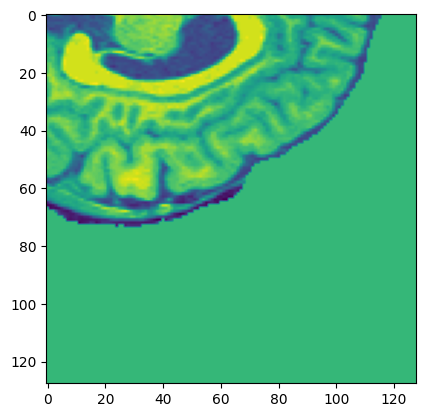

In [27]:

plt.imshow(train_sample_np_slice[:, :, 0])

In [28]:
train_sample['image'].shape

torch.Size([2, 1, 128, 128, 128])

In [29]:
train_sample['label'].shape

torch.Size([2, 8, 128, 128, 128])

In [30]:
np.unique(train_sample['label'][0, 0, :, :, :])

array([0., 1.], dtype=float32)

In [31]:
train_sample['label'].shape

torch.Size([2, 8, 128, 128, 128])

In [32]:
# img_add = os.path.join(data_dir, "TrainingData/BraTS2021_00006/BraTS2021_00006_flair.nii.gz")
# label_add = os.path.join(data_dir, "TrainingData/BraTS2021_00006/BraTS2021_00006_seg.nii.gz")
# img = nib.load(img_add).get_fdata()
# label = nib.load(label_add).get_fdata()
# print(f"image shape: {img.shape}, label shape: {label.shape}")
# plt.figure("image", (18, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(img[:, :, 78], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[:, :, 78])
# plt.show()

# 1. Define model and trainer

Note: model is trained originally on 4 channels: t1 is channel 3

In [40]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=1,
    out_channels=8,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

In [41]:
from monai.networks.nets import ViTAutoEnc

# model = ViTAutoEnc(
#     in_channels=1,  # one channels (t1: array)
#     out_channels=3, # out channels and in channels should be the same shape
#     img_size=(96, 96, 96),
#     patch_size=(16, 16, 16),
#     pos_embed="conv",
#     hidden_size=768,
#     mlp_dim=3072,
# )

In [42]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [43]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

In [44]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

# 2. Run training loop

Modification: load pretrained (reconstruction ssl) params

In [45]:
load_pretrained_parmas = False

if load_pretrained_parmas:

    pretrained_model_path = f"{data_dir}/logs-5"
    best_checkpoint = torch.load(f'{pretrained_model_path}/best_model.pt')
    best_state_dict = best_checkpoint['state_dict']  # pretrained parameters
    state_dict = model.state_dict() # randomly intiaiized parameters of current model

    # This supervised model predicts a different output from the pretrained one,
    # so the outputs have a different semantic meaning and different shape.
    # Exclude the final weights from the the weight dictionary and then load

    load_state_dict = {k: v for k, v in best_state_dict.items() if 'conv3d_transpose_1' not in k}

    for k, v in state_dict.items():
        if k not in load_state_dict.keys():
            load_state_dict[k] = v

    model.load_state_dict(load_state_dict)

In [46]:
start_epoch = 0

(
val_acc_max,
dices_tc,
dices_wt,
dices_et,
dices_avg,
loss_epochs,
trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Wed Oct 18 15:21:46 2023 Epoch: 0
Epoch 0/100 0/440 loss: 0.9997 time 131.33s
Epoch 0/100 1/440 loss: 0.9997 time 111.64s
Epoch 0/100 2/440 loss: 0.9997 time 111.19s


KeyboardInterrupt: 

In [ ]:
save = True

codename = 'monai-pretrain-unetr'
date = str(datetime.datetime.today()).split(" ")[0]
save_dir = f'{data_dir}/saved_models'
os.makedirs(save_dir, exist_ok=True)

if save:
    torch.save(model.state_dict(), f"{save_dir}/model_weights_{date}-{codename}.pth")

In [ ]:
os.listdir(save_dir)